In [1]:
import os
import torch
import pandas as pd
import torchaudio
import pandas as pd
import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration, WhisperConfig, WhisperFeatureExtractor
from jiwer import wer
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
def create_file_mapping(transcript_dir, audio_dir):
    """
    Creates a DataFrame mapping transcript files to their corresponding audio files based on filenames.
    
    Args:
        transcript_dir (str): Directory containing transcript text files.
        audio_dir (str): Directory containing audio files.
    
    Returns:
        pd.DataFrame: DataFrame with columns 'Interview', 'Transcript Path', and 'Audio Path'.
    """
    # Get lists of file paths
    transcript_files = [f for f in os.listdir(transcript_dir) if f.endswith('.txt')]
    audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]
    
    # Extract file identifiers from filenames
    transcript_ids = {os.path.splitext(f)[0] for f in transcript_files}
    audio_ids = {os.path.splitext(f)[0] for f in audio_files}
    
    # Determine the intersection of transcript and audio IDs
    common_ids = transcript_ids.intersection(audio_ids)
    
    # Create the mapping dictionary
    file_mapping = {
        'Interview': [],
        'Transcript Path': [],
        'Audio Path': []
    }
    
    for file_id in common_ids:
        transcript_path = os.path.join(transcript_dir, file_id + '.txt')
        audio_path = os.path.join(audio_dir, file_id + '.wav')
        file_mapping['Interview'].append(file_id)
        file_mapping['Transcript Path'].append(transcript_path)
        file_mapping['Audio Path'].append(audio_path)
    
    # Convert the dictionary to a DataFrame
    return pd.DataFrame(file_mapping)


def process_transcripts(paths_df):
    """
    Processes transcript files to extract and format relevant data, and combines them into a single DataFrame.
    
    Args:
        paths_df (pd.DataFrame): DataFrame with columns 'Interview', 'Transcript Path', and 'Audio Path'.
    
    Returns:
        pd.DataFrame: DataFrame containing concatenated and processed transcript data.
    """
    all_transcript_data = []
    
    for _, row in paths_df.iterrows():
        transcript_path = row['Transcript Path']
        
        # Load transcript data with appropriate delimiter and columns
        transcript_df = pd.read_csv(transcript_path, delimiter="\t", usecols=['StTime', 'EnTime', 'Content'])
        
        # Convert times from minutes to milliseconds
        transcript_df['StTime'] *= 1000
        transcript_df['EnTime'] *= 1000
        
        # Standardize content to uppercase
        transcript_df['Content'] = transcript_df['Content'].str.upper()
        
        # Add the identifier column
        transcript_df['Interview'] = row['Interview']
        
        # Append to the list
        all_transcript_data.append(transcript_df)
    
    # Combine all transcript data into a single DataFrame
    return pd.concat(all_transcript_data, ignore_index=True)


In [3]:
# Load your data
transcript_dir = '../data/coraal/transcript/text/'
audio_dir = '../data/coraal/audio/wav/'

paths_df = create_file_mapping(transcript_dir, audio_dir)
combined_transcript_df = process_transcripts(paths_df)
display(combined_transcript_df.sample(10))

,StTime,Content,EnTime,Interview
3276,1850298.5,LIKE,1850643.9,ATL_se0_ag1_m_03_1
15099,173481.5,"BECAUSE WHEN YOU ENTER THIS SYSTEM, YOU GOT KA...",176417.7,ATL_se0_ag2_m_01_1
8008,1014790.2,DANG.,1015480.4,ATL_se0_ag2_f_02_1
15184,284057.8,WITH SHIT. IT'S PART OF THE SYSTEM TOO.,286044.6,ATL_se0_ag2_m_01_1
7965,952201.9,(PAUSE 0.22),952424.1,ATL_se0_ag2_f_02_1
4693,747829.0,YEAH.,748213.6,ATL_se0_ag1_f_01_1
13360,709459.0,(PAUSE 0.43),709887.0,ATL_se0_ag2_m_02_1
3411,1977032.9,APT TO SEE GROWTH. LIKE THEY'LL- LIKE IF YOU,1979521.7,ATL_se0_ag1_m_03_1
15952,1362525.3,JUMPING OUT HERE SCARED,1363892.4,ATL_se0_ag2_m_01_1
11259,814339.1,(PAUSE 0.27),814607.5,ATL_se0_ag1_m_02_1


In [4]:
# Filter out rows with unwanted characters in the 'Content' column
pattern = r'[\(\)\[\]/<>]'
filtered_transcript_df = combined_transcript_df[~combined_transcript_df['Content'].str.contains(pattern)].reset_index(drop=True)
display(filtered_transcript_df.sample(10))

,StTime,Content,EnTime,Interview
7634,577104.5,"MY DAD'S SIDE- I MEAN, I HAVE SOME THAT LIVE I...",581055.7,ATL_se0_ag1_f_03_1
872,310256.3,"BEING THAT IT'S LIKE,",311245.6,ATL_se0_ag1_m_03_1
3574,1860637.3,BETTER,1861203.7,ATL_se0_ag2_f_02_1
4111,1067219.7,THAN OTHERS,1068225.1,ATL_se0_ag1_m_05_1
7820,1114090.2,"UM,",1114770.2,ATL_se0_ag1_f_03_1
3988,603685.7,"MOTHER AND FATHER, AND THEY AROUND THE SAME AG...",608041.0,ATL_se0_ag1_m_05_1
7026,2211069.3,THAT'S A INVESTMENT.,2212239.5,ATL_se0_ag2_m_01_1
3124,411784.0,DON'T REALLY THINK ABOUT HIM.,413218.5,ATL_se0_ag2_f_02_1
7743,903435.2,OKAY.,903974.9,ATL_se0_ag1_f_03_1
5328,2266273.6,AND,2266707.2,ATL_se0_ag1_m_02_1


In [7]:
filtered_transcript_df.head(20)

,StTime,Content,EnTime,Interview
0,777.4,OKAY.,1396.7,ATL_se0_ag2_f_01_1
1,2424.7,HOW'S IT GOING?,3301.4,ATL_se0_ag2_f_01_1
2,6013.9,I'M THE GUY THAT'S GONNA BE INTERVIEWI-,7893.1,ATL_se0_ag2_f_01_1
3,9661.9,CAN I START BY YOUR NAME? WHAT'S YOUR NAME?,11326.5,ATL_se0_ag2_f_01_1
4,16053.6,"UM,",16688.0,ATL_se0_ag2_f_01_1
5,17991.5,"WITH A NAME LIKE THAT, I'M ASSUMING YOU'RE FEM...",19951.2,ATL_se0_ag2_f_01_1
6,20211.8,BUT Y-,20766.9,ATL_se0_ag2_f_01_1
7,20877.2,"FOR THE RECORD, ARE YOU FEMALE?",22585.6,ATL_se0_ag2_f_01_1
8,22749.9,I'M A FEMALE.,23845.6,ATL_se0_ag2_f_01_1
9,24192.5,OKAY YOUR ETHNICITY?,25500.7,ATL_se0_ag2_f_01_1


In [24]:
coraal_manifest_df = pd.DataFrame({
    'audio_filepath': audio_dir + filtered_transcript_df['Interview'] + ".wav",
    'start_time': filtered_transcript_df['StTime'],
    'end_time': filtered_transcript_df['EnTime'],
    'text': filtered_transcript_df['Content']
})

# Save the DataFrame to a JSON file
coraal_manifest_df.to_json('../data/coraal/coraal-atl_manifest.json', orient='records', lines=True)

# Verify by loading the JSON file
coraal_manifest = pd.read_json('../data/coraal/coraal-atl_manifest.json', lines=True)
display(coraal_manifest.head())

,audio_filepath,start_time,end_time,text
0,../data/coraal/audio/wav/ATL_se0_ag2_f_01_1.wav,777.4,1396.7,OKAY.
1,../data/coraal/audio/wav/ATL_se0_ag2_f_01_1.wav,2424.7,3301.4,HOW'S IT GOING?
2,../data/coraal/audio/wav/ATL_se0_ag2_f_01_1.wav,6013.9,7893.1,I'M THE GUY THAT'S GONNA BE INTERVIEWI-
3,../data/coraal/audio/wav/ATL_se0_ag2_f_01_1.wav,9661.9,11326.5,CAN I START BY YOUR NAME? WHAT'S YOUR NAME?
4,../data/coraal/audio/wav/ATL_se0_ag2_f_01_1.wav,16053.6,16688.0,"UM,"


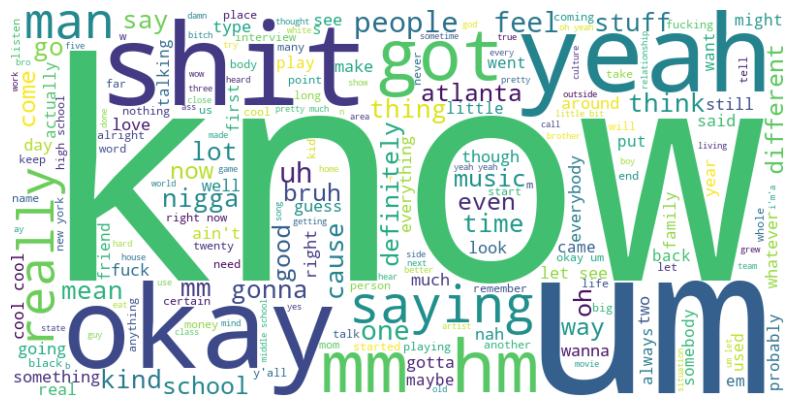

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text into a single string
all_text = ' '.join(coraal_manifest['text'].str.lower())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
